In [1]:
#this method of P value is calculated based on all diseases from disease ontology.
#can not filter to alz disease first and do calculation

## Compute symptom-disease cooccurrence for Hetionet

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
download_dir = '../data/MEDLINE'

In [3]:
import io
import gzip

import pandas
import requests
import networkx

#import eutility
#import cooccurrence

## defined functions

In [7]:
#https://www.ncbi.nlm.nih.gov/books/NBK25500/
"""
import time

import xml.etree.ElementTree as ET

import requests

def esearch_query(payload, retmax = 100, sleep=2):
    #Query the esearch E-utility.
    #This function can not get results more than 10000
    url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'
    payload['retmax'] = retmax
    payload['retstart'] = 0
    ids = list()
    count = 1
    while payload['retstart'] < count:
        response = requests.get(url, params=payload)
        xml = ET.fromstring(response.content)
        if xml.findtext('Count') is not None:
            count = int(xml.findtext('Count'))
        ids += [xml_id.text for xml_id in xml.findall('IdList/Id')]
        payload['retstart'] += retmax
        time.sleep(sleep)
    return ids
"""

"\nimport time\n\nimport xml.etree.ElementTree as ET\n\nimport requests\n\ndef esearch_query(payload, retmax = 100, sleep=2):\n    #Query the esearch E-utility.\n    #This function can not get results more than 10000\n    url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'\n    payload['retmax'] = retmax\n    payload['retstart'] = 0\n    ids = list()\n    count = 1\n    while payload['retstart'] < count:\n        response = requests.get(url, params=payload)\n        xml = ET.fromstring(response.content)\n        if xml.findtext('Count') is not None:\n            count = int(xml.findtext('Count'))\n        ids += [xml_id.text for xml_id in xml.findall('IdList/Id')]\n        payload['retstart'] += retmax\n        time.sleep(sleep)\n    return ids\n"

In [6]:
import subprocess
import re

# Function to format disease name into a valid file name
def format_filename(name):
    # Replace spaces with underscores and remove special characters
    filename = re.sub(r'\W+', '_', name.strip())
    # Add suffix
    #return os.path.join(download_dir, filename + "result.txt")
    return filename + "result.txt"

# fetching data for {query_term}. Results saved in {output_file}
def efetch_query(query_term):
    # Run the command with the current disease name and output file name
    output_file = format_filename(query_term)
    command = f'esearch -db pubmed -query "{query_term}" | efetch -format xml | xtract -pattern PubmedArticle -element MedlineCitation/PMID > {output_file}'
    subprocess.run(command, shell=True)

    print(f"Completed fetching data for {query_term}. Results saved in {output_file}")
    return output_file


In [5]:
import itertools
from typing import Any, Dict, List, Set

import scipy.stats
import pandas


def read_pmids_tsv(path, key, min_articles = 1):
    term_to_pmids = dict()
    pmids_df = pandas.read_table(path, compression='gzip')
    pmids_df = pmids_df[pmids_df.n_articles >= min_articles]
    for i, row in pmids_df.iterrows():
        term = row[key]
        pmids = row.pubmed_ids.split('|')
        term_to_pmids[term] = set(pmids)
    pmids_df.drop('pubmed_ids', axis=1, inplace=True)
    return pmids_df, term_to_pmids

def score_pmid_cooccurrence(term0_to_pmids, term1_to_pmids, term0_name='term_0', term1_name='term_1', verbose=True):
    """
    Find pubmed cooccurrence between topics of two classes.

    term0_to_pmids -- a dictionary that returns the pubmed_ids for each term of class 0
    term0_to_pmids -- a dictionary that returns the pubmed_ids for each term of class 1
    """
    all_pmids0 = set.union(*term0_to_pmids.values())
    all_pmids1 = set.union(*term1_to_pmids.values())
    pmids_in_both = all_pmids0 & all_pmids1
    total_pmids = len(pmids_in_both)
    if verbose:
        print('Total articles containing a {}: {}'.format(term0_name, len(all_pmids0)))
        print('Total articles containing a {}: {}'.format(term1_name, len(all_pmids1)))
        print('Total articles containing both a {} and {}: {}'.format(term0_name, term1_name, total_pmids))

    term0_to_pmids = term0_to_pmids.copy()
    term1_to_pmids = term1_to_pmids.copy()
    for d in term0_to_pmids, term1_to_pmids:
        for key, value in list(d.items()):
            d[key] = value & pmids_in_both
            if not d[key]:
                del d[key]

    if verbose:
        print('\nAfter removing terms without any cooccurences:')
        print('+ {} {}s remain'.format(len(term0_to_pmids), term0_name))
        print('+ {} {}s remain'.format(len(term1_to_pmids), term1_name))

    rows = list()
    for term0, term1 in itertools.product(term0_to_pmids, term1_to_pmids):
        pmids0 = term0_to_pmids[term0]
        pmids1 = term1_to_pmids[term1]
        row = {
            term0_name: term0,
            term1_name: term1,
            **cooccurrence_metrics(pmids0, pmids1, total_pmids=total_pmids)
        }
        rows.append(row)
    df = pandas.DataFrame(rows)

    if verbose:
        print('\nCooccurrence scores calculated for {} {} -- {} pairs'.format(len(df), term0_name, term1_name))
    return df

In [9]:
def cooccurrence_metrics(source_pmids: Set[str], target_pmids: Set[str], total_pmids: int) -> Dict[str, Any]:
    """
    Compute metrics of cooccurrence between two sets of pubmed ids.
    Requires providing the total number of pubmed ids in the corpus.
    """
    a = len(source_pmids & target_pmids)
    b = len(source_pmids) - a
    c = len(target_pmids) - a
    d = total_pmids - (a + b + c)
    contingency_table = [[a, b], [c, d]]
    # discussion on this formula in https://github.com/hetio/medline/issues/1
    expected = len(source_pmids) * len(target_pmids) / total_pmids
    enrichment = a / expected
    odds_ratio, p_fisher = scipy.stats.fisher_exact(contingency_table, alternative='greater')
    return {
        "cooccurrence": a,
        "expected": expected,
        "enrichment": enrichment,
        "odds_ratio": odds_ratio,
        "p_fisher": p_fisher,
        "n_source": len(source_pmids),
        "n_target": len(target_pmids),
    }

# Diseases

In [10]:
#install e-direct by following https://www.ncbi.nlm.nih.gov/books/NBK179288/
#run with vpn

In [5]:
# Read mappings for DO Slim terms
url = '../data/DiseaseOntology/xrefs-slim.tsv'
disease_df = pandas.read_table(url)
disease_df = disease_df.query('resource == "MESH"').drop(columns=['resource']) #change MSH to MESH
disease_df = disease_df.rename(columns={'resource_id': 'mesh_id'})
disease_df.shape

# Read MeSH terms to MeSH names
url = '../data/MESH/terms.tsv'
mesh_df = pandas.read_table(url)
disease_df = disease_df.merge(mesh_df)
disease_df.shape

# Manually remove problematic xrefs
# https://github.com/obophenotype/human-disease-ontology/issues/45
disease_df = disease_df.query("mesh_id != 'D003327' and mesh_id != 'D017202'")
disease_df.shape
disease_df.head()

(127, 3)

(127, 4)

(125, 4)

,doid_code,doid_name,mesh_id,mesh_name
0,DOID:2531,hematologic cancer,D019337,Hematologic Neoplasms
1,DOID:1319,brain cancer,D001932,Brain Neoplasms
2,DOID:263,kidney cancer,D007680,Kidney Neoplasms
3,DOID:1793,pancreatic cancer,D010190,Pancreatic Neoplasms
4,DOID:4159,skin cancer,D012878,Skin Neoplasms


In [ ]:
import pandas

rows_out = list()

for i, row in disease_df.iterrows():
    term_query = '{disease}[MeSH Major Topic]'.format(disease = row.mesh_name.lower())
    print(term_query)
    #payload = {'db': 'pubmed', 'term': term_query}
    #pmids = esearch_query(payload, retmax = 10000)
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

disease_pmids_df = pandas.DataFrame(rows_out)

validate with the url (open with chrome) https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=alzheimer%20disease[MeSH%20Major%20Topic]

In [ ]:
# rerun case with error
error_terms = ['Stomach Neoplasms', 'Urinary Bladder Neoplasms', 'Neoplasms, Germ Cell and Embryonal'
              ]
error_out = list()
for i in error_terms:
    term_query = '{disease}[MeSH Major Topic]'.format(disease = i.lower())
    print(term_query)
    row = disease_pmids_df.loc[disease_pmids_df['mesh_name'] == i].squeeze()
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    error_out.append(row)
    print('{} articles for {}'.format(len(pmids), i))

disease_error_df = pandas.DataFrame(error_out)
disease_error_df

In [64]:
#validate with first run
disease_pmids_df.loc[disease_pmids_df['mesh_name'].isin(error_terms)]

,doid_code,doid_name,mesh_id,mesh_name,term_query,n_articles,pubmed_ids
14,DOID:10534,stomach cancer,D013274,Stomach Neoplasms,stomach neoplasms[MeSH Major Topic],98656,2794|3839|7075|7818|7958|11530|14374|14377|175...
15,DOID:11054,urinary bladder cancer,D001749,Urinary Bladder Neoplasms,urinary bladder neoplasms[MeSH Major Topic],55298,6146|12890|13929|26492|33571|36123|36278|36279...
27,DOID:2994,germ cell cancer,D009373,"Neoplasms, Germ Cell and Embryonal","neoplasms, germ cell and embryonal[MeSH Major ...",335022,471|1140|1456|1745|1891|2828|3117|3627|3662|36...


In [67]:
#update results and check values
disease_pmids_df.loc[disease_pmids_df.mesh_name.isin(disease_error_df.mesh_name), ['n_articles', 'pubmed_ids']] = disease_error_df[['n_articles', 'pubmed_ids']]
disease_pmids_df.loc[disease_pmids_df['mesh_name'].isin(error_terms)]

,doid_code,doid_name,mesh_id,mesh_name,term_query,n_articles,pubmed_ids
14,DOID:10534,stomach cancer,D013274,Stomach Neoplasms,stomach neoplasms[MeSH Major Topic],99119,2794|3839|7075|7818|7958|11530|14374|14377|175...
15,DOID:11054,urinary bladder cancer,D001749,Urinary Bladder Neoplasms,urinary bladder neoplasms[MeSH Major Topic],55940,6146|12890|13929|26492|33571|36123|36278|36279...
27,DOID:2994,germ cell cancer,D009373,"Neoplasms, Germ Cell and Embryonal","neoplasms, germ cell and embryonal[MeSH Major ...",335043,471|1140|1456|1745|1891|2828|3117|3627|3662|36...


In [71]:
with gzip.open(os.path.join(download_dir,'disease-pmids.tsv.gz'), 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    disease_pmids_df.to_csv(write_file, sep='\t', index=False)

In [89]:
disease_pmids_df.shape

(125, 7)

# disease-disease-cooccurrence

In [7]:
download_dir = '../data/MEDLINE'
disease_df, disease_to_pmids = read_pmids_tsv(os.path.join(download_dir,'disease-pmids.tsv.gz'), key='doid_code')

In [10]:
cooc_df = score_pmid_cooccurrence(disease_to_pmids, disease_to_pmids, 'doid_code_0', 'doid_code_1')

Total articles containing a doid_code_0: 4906736
Total articles containing a doid_code_1: 4906736
Total articles containing both a doid_code_0 and doid_code_1: 4906736

After removing terms without any cooccurences:
+ 121 doid_code_0s remain
+ 121 doid_code_1s remain

Cooccurrence scores calculated for 14641 doid_code_0 -- doid_code_1 pairs


In [11]:
disease_df.head()

,doid_code,doid_name,mesh_id,mesh_name,term_query,n_articles
0,DOID:2531,hematologic cancer,D019337,Hematologic Neoplasms,hematologic neoplasms[MeSH Major Topic],20412
1,DOID:1319,brain cancer,D001932,Brain Neoplasms,brain neoplasms[MeSH Major Topic],148009
2,DOID:263,kidney cancer,D007680,Kidney Neoplasms,kidney neoplasms[MeSH Major Topic],74244
3,DOID:1793,pancreatic cancer,D010190,Pancreatic Neoplasms,pancreatic neoplasms[MeSH Major Topic],80499
4,DOID:4159,skin cancer,D012878,Skin Neoplasms,skin neoplasms[MeSH Major Topic],175588


In [12]:
cooc_df.head()

,doid_code_0,doid_code_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:2531,DOID:2531,20412,84.913829,240.384872,inf,0.0,20412,20412
1,DOID:2531,DOID:1319,104,615.716784,0.168909,0.164065,1.0,20412,148009
2,DOID:2531,DOID:263,68,308.854711,0.220168,0.216844,1.0,20412,74244
3,DOID:2531,DOID:1793,22,334.875483,0.065696,0.064432,1.0,20412,80499
4,DOID:2531,DOID:4159,318,730.445301,0.435351,0.425374,1.0,20412,175588


In [13]:
cooc_df = cooc_df[cooc_df['doid_code_0'] != cooc_df['doid_code_1']]
doid_name_df = disease_df[['doid_code', 'doid_name']].drop_duplicates()
cooc_df = doid_name_df.rename(columns={'doid_code': 'doid_code_1', 'doid_name': 'doid_name_1'}).merge(cooc_df)
cooc_df = doid_name_df.rename(columns={'doid_code': 'doid_code_0', 'doid_name': 'doid_name_0'}).merge(cooc_df)
cooc_df = cooc_df.sort_values(by=['doid_name_0', 'p_fisher'])

In [14]:
cooc_df.head()

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
7866,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2521,1562.065225,1.613889,1.651428,8.873145e-115,104084,73639
7886,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,157,116.223134,1.350850,1.361746,1.558560e-04,104084,5479
7878,DOID:10652,Alzheimer's disease,DOID:332,amyotrophic lateral sclerosis,330,451.698379,0.730576,0.725465,1.000000e+00,104084,21294
7800,DOID:10652,Alzheimer's disease,DOID:2531,hematologic cancer,2,432.988978,0.004619,0.004502,1.000000e+00,104084,20412
7801,DOID:10652,Alzheimer's disease,DOID:1319,brain cancer,51,3139.636768,0.016244,0.015422,1.000000e+00,104084,148009


In [15]:
len(cooc_df)

14520

In [16]:
len(cooc_df[cooc_df.p_fisher <= 0.005])

500

In [18]:
cooc_df.to_csv(os.path.join(download_dir,'disease-disease-cooccurrence.tsv'), index=False, sep='\t')

# Symptoms

In [14]:
# Read MeSH Symptoms
url = '../data/MESH/symptoms.tsv'
symptom_df = pandas.read_table(url)
symptom_df.shape #505

(505, 3)

In [15]:
url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/symptoms.tsv'
hetionet_symptom_df = pandas.read_table(url)
hetionet_symptom_ls = hetionet_symptom_df['mesh_name'].tolist()
len(hetionet_symptom_ls)

438

In [ ]:
rows_out = list()

for i, row in symptom_df.iterrows(): 
    term_query = '{symptom}[MeSH Terms:noexp]'.format(symptom = row.mesh_name.lower())
    print(row.mesh_name)
    if row.mesh_name in hetionet_symptom_ls: # ran thoes terms previously when validating code
        path = os.path.join('..s/data/MEDLINE/dhimmel_medline/esearch', format_filename(term_query))
        pmids = pandas.read_csv(path, header=None, names=['pmids'])
    else:
        path = efetch_query(term_query)
        path = os.path.join(os.getcwd(), path)
        pmids = pandas.read_csv(path, header=None, names=['pmids'])
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))
    
symptom_pmids_df = pandas.DataFrame(rows_out)

In [17]:
rows_out

[mesh_id                                                 D000006
 mesh_name                                        Abdomen, Acute
 in_hsdn                                                       1
 term_query                     abdomen, acute[MeSH Terms:noexp]
 n_articles                                                 9939
 pubmed_ids    11344|28849|29373|38875|42826|45697|46444|4762...
 Name: 0, dtype: object,
 mesh_id                                              D000067329
 mesh_name                         Obesity, Metabolically Benign
 in_hsdn                                                       0
 term_query      obesity, metabolically benign[MeSH Terms:noexp]
 n_articles                                                  498
 pubmed_ids    23928805|24670711|25443068|25449143|25515498|2...
 Name: 1, dtype: object,
 mesh_id                                              D000067404
 mesh_name                         Social Communication Disorder
 in_hsdn                                

validate with the url (open with chrome) https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=adie%20syndrome[MeSH%20Terms%3Anoexp] 

In [72]:
# rerun case with error
error_terms = ['Dyspnea', 'Edema', 'Fatigue', 'Fetal Distress']

error_out = list()
for i in error_terms:
    term_query = '{symptom}[MeSH Terms:noexp]'.format(symptom = i.lower())
    print(term_query)
    row = symptom_pmids_df.loc[symptom_pmids_df['mesh_name'] == i].squeeze()
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    error_out.append(row)
    print('{} articles for {}'.format(len(pmids), i))

symptom_error_df = pandas.DataFrame(error_out)
symptom_error_df

dyspnea[MeSH Terms:noexp]


.......


Completed fetching data for dyspnea[MeSH Terms:noexp]. Results saved in dyspnea_MeSH_Terms_noexp_result.txt
25667 articles for Dyspnea
edema[MeSH Terms:noexp]


...........


Completed fetching data for edema[MeSH Terms:noexp]. Results saved in edema_MeSH_Terms_noexp_result.txt
43912 articles for Edema
fatigue[MeSH Terms:noexp]


...........


Completed fetching data for fatigue[MeSH Terms:noexp]. Results saved in fatigue_MeSH_Terms_noexp_result.txt
36458 articles for Fatigue
fetal distress[MeSH Terms:noexp]
Completed fetching data for fetal distress[MeSH Terms:noexp]. Results saved in fetal_distress_MeSH_Terms_noexp_result.txt
3541 articles for Fetal Distress


,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
130,D004417,Dyspnea,1,dyspnea[MeSH Terms:noexp],25667,4751|4753|8819|9881|10809|10813|10814|10820|24...
136,D004487,Edema,1,edema[MeSH Terms:noexp],43912,515|657|973|1042|1049|2693|4901|5887|7668|8042...
152,D005221,Fatigue,1,fatigue[MeSH Terms:noexp],36458,1333|3032|4054|5019|7710|7923|10321|10513|1714...
156,D005316,Fetal Distress,1,fetal distress[MeSH Terms:noexp],3541,480|2544|3546|3899|5585|5894|5895|6366|6505|86...


In [73]:
#validate with first run
symptom_pmids_df.loc[symptom_pmids_df['mesh_name'].isin(error_terms)]

,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
130,D004417,Dyspnea,1,dyspnea[MeSH Terms:noexp],25604,4751|4753|8819|9881|10809|10813|10814|10820|24...
136,D004487,Edema,1,edema[MeSH Terms:noexp],43264,515|657|973|1042|1049|2693|4901|5887|7668|8042...
152,D005221,Fatigue,1,fatigue[MeSH Terms:noexp],35781,1333|3032|4054|5019|7710|7923|10321|10513|1714...
156,D005316,Fetal Distress,1,fetal distress[MeSH Terms:noexp],3421,480|2544|3546|3899|5585|5894|5895|6366|6505|86...


In [74]:
#update results and check values
symptom_pmids_df.loc[symptom_pmids_df.mesh_name.isin(symptom_error_df.mesh_name), ['n_articles', 'pubmed_ids']] = symptom_error_df[['n_articles', 'pubmed_ids']]
symptom_pmids_df.loc[symptom_pmids_df['mesh_name'].isin(error_terms)]

,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
130,D004417,Dyspnea,1,dyspnea[MeSH Terms:noexp],25667,4751|4753|8819|9881|10809|10813|10814|10820|24...
136,D004487,Edema,1,edema[MeSH Terms:noexp],43912,515|657|973|1042|1049|2693|4901|5887|7668|8042...
152,D005221,Fatigue,1,fatigue[MeSH Terms:noexp],36458,1333|3032|4054|5019|7710|7923|10321|10513|1714...
156,D005316,Fetal Distress,1,fetal distress[MeSH Terms:noexp],3541,480|2544|3546|3899|5585|5894|5895|6366|6505|86...


In [75]:
with gzip.open(os.path.join(download_dir,'symptom-pmids.tsv.gz'), 'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    symptom_pmids_df.to_csv(write_file, sep='\t', index=False)

In [76]:
symptom_pmids_df.shape

(505, 6)

In [77]:
symptom_pmids_df[symptom_pmids_df['n_articles']>=1]

,mesh_id,mesh_name,in_hsdn,term_query,n_articles,pubmed_ids
0,D000006,"Abdomen, Acute",1,"abdomen, acute[MeSH Terms:noexp]",9939,11344|28849|29373|38875|42826|45697|46444|4762...
1,D000067329,"Obesity, Metabolically Benign",0,"obesity, metabolically benign[MeSH Terms:noexp]",498,23928805|24670711|25443068|25449143|25515498|2...
2,D000067404,Social Communication Disorder,0,social communication disorder[MeSH Terms:noexp],122,22928858|24659736|24756919|25039503|25240938|2...
3,D000067454,Childhood-Onset Fluency Disorder,0,childhood-onset fluency disorder[MeSH Terms:no...,4,26296615|30142643|32013722|32267336
4,D000067559,Specific Learning Disorder,0,specific learning disorder[MeSH Terms:noexp],88,25124507|25243500|25349093|25609675|25807176|2...
...,...,...,...,...,...,...
500,D065634,Cerebrospinal Fluid Leak,0,cerebrospinal fluid leak[MeSH Terms:noexp],2092,13010347|13997991|14205478|14254367|20443757|2...
501,D065635,Benign Paroxysmal Positional Vertigo,0,benign paroxysmal positional vertigo[MeSH Term...,1335,14152207|17702417|18300443|20015792|20053308|2...
502,D065906,Hyperlactatemia,0,hyperlactatemia[MeSH Terms:noexp],260,13716482|22321745|23612027|23704758|23995586|2...
503,D066190,Allesthesia,0,allesthesia[MeSH Terms:noexp],10,13049863|14257835|14264701|14770594|14959140|1...


In [21]:
#url = 'https://raw.githubusercontent.com/dhimmel/mesh/e561301360e6de2140dedeaa7c7e17ce4714eb7f/data/symptoms.tsv'
#check2 = pandas.read_table(url)
#check2.shape
#check = check2.merge(symptom_pmids_df, on=['mesh_id','mesh_name','in_hsdn'], how='outer', indicator=True)
#check['_merge'].unique()

# Cooccurrence

In [78]:
import os
symptom_df, symptom_to_pmids = read_pmids_tsv(os.path.join(download_dir,'symptom-pmids.tsv.gz'), key='mesh_id')
disease_df, disease_to_pmids = read_pmids_tsv(os.path.join(download_dir,'disease-pmids.tsv.gz'), key='doid_code')
#disease_df, disease_to_pmids = read_pmids_tsv('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/disease-pmids.tsv.gz', key='doid_code')

In [79]:
symptom_pmids = set.union(*symptom_to_pmids.values())
len(symptom_pmids)

2590578

In [80]:
disease_pmids = set.union(*disease_to_pmids.values())
len(disease_pmids)

4906736

In [82]:
cooc_df = score_pmid_cooccurrence(disease_to_pmids, symptom_to_pmids, 'doid_code', 'mesh_id')

Total articles containing a doid_code: 4906736
Total articles containing a mesh_id: 2590578
Total articles containing both a doid_code and mesh_id: 541067

After removing terms without any cooccurences:
+ 121 doid_codes remain
+ 488 mesh_ids remain

Cooccurrence scores calculated for 59048 doid_code -- mesh_id pairs


In [83]:
cooc_df = symptom_df[['mesh_id', 'mesh_name']].drop_duplicates().merge(cooc_df)
cooc_df = disease_df[['doid_code', 'doid_name']].drop_duplicates().merge(cooc_df)
cooc_df = cooc_df.sort_values(by=['doid_name', 'p_fisher'])
cooc_df.to_csv(os.path.join(download_dir,'disease-symptom-cooccurrence.tsv'), index=False, sep='\t')
cooc_df.shape
cooc_df.head() #59048

(59048, 11)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
31772,DOID:10652,Alzheimer's disease,D000647,Amnesia,489,19.641482,24.896288,48.294582,0.0,10199,1042
31834,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,1102,56.021580,19.670991,34.268557,0.0,10199,2972
31902,DOID:10652,Alzheimer's disease,D006816,Huntington Disease,397,20.075028,19.775813,32.146898,0.0,10199,1065
31930,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,2856,132.966427,21.479106,48.795618,0.0,10199,7054
31975,DOID:10652,Alzheimer's disease,D011595,Psychomotor Agitation,453,24.994823,18.123753,28.218201,0.0,10199,1326


In [84]:
disease_symptom_df = cooc_df
disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df = disease_symptom_df[disease_symptom_df['doid_code'].isin(['DOID:10652','DOID:11949'])]
disease_symptom_df.to_csv(os.path.join(download_dir,'symptomManifestationOfDisease.tsv'), index=False, sep='\t')
disease_symptom_df.shape

(91, 11)

## Compare with Hetionet

In [85]:
#compare with hetionet version  79 rels
Dps_hetionet = pandas.read_table('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/disease-symptom-cooccurrence.tsv') 
Dps_hetionet = Dps_hetionet[Dps_hetionet['doid_code'].isin(['DOID:10652','DOID:11949'])]
Dps_hetionet = Dps_hetionet[Dps_hetionet.p_fisher < 0.005]
Dps_hetionet.shape

(79, 9)

In [86]:
check3 = Dps_hetionet.merge(disease_symptom_df, on=['doid_code','mesh_id'], how='outer', indicator=True)
check3['_merge'].unique()
check3[(check3['_merge']=='left_only')]

['both', 'left_only', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

,doid_code,doid_name_x,mesh_id,mesh_name_x,cooccurrence_x,expected_x,enrichment_x,odds_ratio_x,p_fisher_x,doid_name_y,mesh_name_y,cooccurrence_y,expected_y,enrichment_y,odds_ratio_y,p_fisher_y,n_source,n_target,_merge
19,DOID:10652,Alzheimer's disease,D000425,Alcohol Amnestic Disorder,51.0,5.711363,8.929567,10.341223,3.887655e-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
38,DOID:10652,Alzheimer's disease,D020233,"Gait Disorders, Neurologic",36.0,17.118001,2.103049,2.148741,3.758550e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
42,DOID:10652,Alzheimer's disease,D009127,Muscle Rigidity,17.0,8.188969,2.075963,2.116383,4.291833e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
70,DOID:11949,Creutzfeldt-Jakob disease,D018888,"Aphasia, Primary Progressive",2.0,0.053046,37.702979,39.306266,1.331623e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
77,DOID:11949,Creutzfeldt-Jakob disease,D019569,Hemifacial Spasm,2.0,0.100306,19.939075,20.421091,4.655519e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


validate with the url (open with chrome) https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=alzheimer%20disease[MeSH%20Major%20Topic]%26Muscle%20Rigidity[MeSH%20Terms%3Anoexp]

In [92]:
#p value larger than 0.005
cooc_df[(cooc_df['mesh_id'].isin(['D000425','D020233','D009127']))&(cooc_df['doid_code']=='DOID:10652')]

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
31939,DOID:10652,Alzheimer's disease,D009127,Muscle Rigidity,20,11.856519,1.686836,1.710786,0.018007,10199,629
32097,DOID:10652,Alzheimer's disease,D020233,"Gait Disorders, Neurologic",60,46.860581,1.280394,1.289029,0.034611,10199,2486


In [95]:
# mesh id does not exists in new version
symptom_df[symptom_df['mesh_id']=='D000425'] 

,mesh_id,mesh_name,in_hsdn,term_query,n_articles


In [36]:
"""
symptom_df_hetionet, symptom_to_pmids_hetionet = read_pmids_tsv('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/symptom-pmids.tsv.gz', key='mesh_id')
disease_df_hetionet, disease_to_pmids_hetionet = read_pmids_tsv('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/disease-pmids.tsv.gz', key='doid_code')
cooc_df_hetionet =score_pmid_cooccurrence(disease_to_pmids_hetionet, symptom_to_pmids_hetionet, 'doid_code', 'mesh_id')
cooc_df_hetionet = symptom_df[['mesh_id', 'mesh_name']].drop_duplicates().merge(cooc_df_hetionet)
cooc_df_hetionet = disease_df[['doid_code', 'doid_name']].drop_duplicates().merge(cooc_df_hetionet)
cooc_df_hetionet = cooc_df_hetionet.sort_values(by=['doid_name', 'p_fisher'])
cooc_df_hetionet['mesh_id'].nunique()

checklist = cooc_df['mesh_id'].tolist()
cooc_df_hetionet[~cooc_df_hetionet['mesh_id'].isin(checklist)]['cooccurrence'].unique() #0
"""

"\nsymptom_df_hetionet, symptom_to_pmids_hetionet = read_pmids_tsv('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/symptom-pmids.tsv.gz', key='mesh_id')\ndisease_df_hetionet, disease_to_pmids_hetionet = read_pmids_tsv('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/disease-pmids.tsv.gz', key='doid_code')\ncooc_df_hetionet =score_pmid_cooccurrence(disease_to_pmids_hetionet, symptom_to_pmids_hetionet, 'doid_code', 'mesh_id')\ncooc_df_hetionet = symptom_df[['mesh_id', 'mesh_name']].drop_duplicates().merge(cooc_df_hetionet)\ncooc_df_hetionet = disease_df[['doid_code', 'doid_name']].drop_duplicates().merge(cooc_df_hetionet)\ncooc_df_hetionet = cooc_df_hetionet.sort_values(by=['doid_name', 'p_fisher'])\ncooc_df_hetionet['mesh_id'].nunique()\n\nchecklist = cooc_df['mesh_id'].tolist()\ncooc_df_hetionet[~cooc_df_hetionet['mesh_id'].isin(checklist)]['cooccurrence'].unique() #0\n"

## Visualization

In [87]:
import numpy
import scipy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

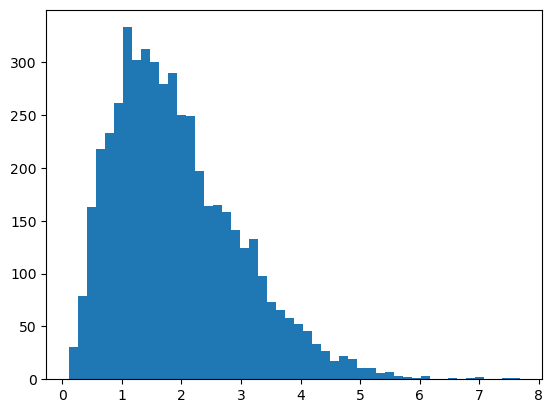

In [88]:
sig_df = cooc_df[cooc_df.p_fisher < 0.05]
plt.hist(list(numpy.log(sig_df.enrichment)), bins = 50);

# Tissues

In [19]:
# Read MeSH UBERON Anatomical structures
url = '../data/Uberon/hetio-slim.tsv'
uberon_df = pandas.read_table(url)
uberon_df.head()

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840
2,UBERON:0000006,islet of Langerhans,D007515,Islets of Langerhans,BTO:0000991
3,UBERON:0000016,endocrine pancreas,D007515,Islets of Langerhans,BTO:0000650
4,UBERON:0000007,pituitary gland,D010902,Pituitary Gland,BTO:0001073


In [42]:
uberon_df.shape

(652, 5)

In [ ]:
#validate with the url (open with chrome) 
#https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Cervix%20Uteri[MeSH%20Terms%3Anoexp]
rows_out = list()

for i, row in uberon_df.iterrows():
    term_query = '{tissue}[MeSH Terms:noexp]'.format(tissue = row.mesh_name.lower())
    print(row.mesh_name)
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    #payload = {'db': 'pubmed', 'term': term_query}
    #pmids = eutility.esearch_query(payload, retmax = 5000, sleep=2)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

uberon_pmids_df = pandas.DataFrame(rows_out)

In [ ]:
#run following terms after being interupted
#tissues_ls = uberon_df['mesh_name'][548:].tolist()
#len(tissues_ls)

for i, row in uberon_df[548:].iterrows(): #11:57
    term_query = '{tissue}[MeSH Terms:noexp]'.format(tissue = row.mesh_name.lower())
    print(row.mesh_name)
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    #payload = {'db': 'pubmed', 'term': term_query}
    #pmids = eutility.esearch_query(payload, retmax = 5000, sleep=2)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

uberon_pmids_df = pandas.DataFrame(rows_out)

In [28]:
#run following terms after being interupted
#tissues_ls = uberon_df['mesh_name'][548:].tolist()
#len(tissues_ls)

for i, row in uberon_df[603:].iterrows(): #internet down at 11:57
    term_query = '{tissue}[MeSH Terms:noexp]'.format(tissue = row.mesh_name.lower())
    print(row.mesh_name)
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    #payload = {'db': 'pubmed', 'term': term_query}
    #pmids = eutility.esearch_query(payload, retmax = 5000, sleep=2)
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    rows_out.append(row)
    print('{} articles for {}'.format(len(pmids), row.mesh_name))

uberon_pmids_df = pandas.DataFrame(rows_out)

Cerebral Crus
Completed fetching data for cerebral crus[MeSH Terms:noexp]. Results saved in cerebral_crus_MeSH_Terms_noexp_result.txt
9 articles for Cerebral Crus
Anterior Hypothalamic Nucleus
Completed fetching data for anterior hypothalamic nucleus[MeSH Terms:noexp]. Results saved in anterior_hypothalamic_nucleus_MeSH_Terms_noexp_result.txt
260 articles for Anterior Hypothalamic Nucleus
Septal Nuclei
Completed fetching data for septal nuclei[MeSH Terms:noexp]. Results saved in septal_nuclei_MeSH_Terms_noexp_result.txt
3672 articles for Septal Nuclei
Vestibular Nuclei
Completed fetching data for vestibular nuclei[MeSH Terms:noexp]. Results saved in vestibular_nuclei_MeSH_Terms_noexp_result.txt
3458 articles for Vestibular Nuclei
Abducens Nucleus
Completed fetching data for abducens nucleus[MeSH Terms:noexp]. Results saved in abducens_nucleus_MeSH_Terms_noexp_result.txt
12 articles for Abducens Nucleus
Nucleus Raphe Obscurus
Completed fetching data for nucleus raphe obscurus[MeSH Terms

...


Completed fetching data for gyrus cinguli[MeSH Terms:noexp]. Results saved in gyrus_cinguli_MeSH_Terms_noexp_result.txt
10620 articles for Gyrus Cinguli
Parahippocampal Gyrus
Completed fetching data for parahippocampal gyrus[MeSH Terms:noexp]. Results saved in parahippocampal_gyrus_MeSH_Terms_noexp_result.txt
1190 articles for Parahippocampal Gyrus
Pulvinar
Completed fetching data for pulvinar[MeSH Terms:noexp]. Results saved in pulvinar_MeSH_Terms_noexp_result.txt
406 articles for Pulvinar
Substantia Innominata
Completed fetching data for substantia innominata[MeSH Terms:noexp]. Results saved in substantia_innominata_MeSH_Terms_noexp_result.txt
838 articles for Substantia Innominata
Pontine Tegmentum
Completed fetching data for pontine tegmentum[MeSH Terms:noexp]. Results saved in pontine_tegmentum_MeSH_Terms_noexp_result.txt
131 articles for Pontine Tegmentum
Periaqueductal Gray
Completed fetching data for periaqueductal gray[MeSH Terms:noexp]. Results saved in periaqueductal_gray_Me

.........


Completed fetching data for trachea[MeSH Terms:noexp]. Results saved in trachea_MeSH_Terms_noexp_result.txt
38969 articles for Trachea
Skull


...........


Completed fetching data for skull[MeSH Terms:noexp]. Results saved in skull_MeSH_Terms_noexp_result.txt
38978 articles for Skull
Skull


...........


Completed fetching data for skull[MeSH Terms:noexp]. Results saved in skull_MeSH_Terms_noexp_result.txt
38978 articles for Skull
Palate, Hard
Completed fetching data for palate, hard[MeSH Terms:noexp]. Results saved in palate_hard_MeSH_Terms_noexp_result.txt
2338 articles for Palate, Hard
Cranial Sutures
Completed fetching data for cranial sutures[MeSH Terms:noexp]. Results saved in cranial_sutures_MeSH_Terms_noexp_result.txt
2458 articles for Cranial Sutures
Fallopian Tubes


.....


Completed fetching data for fallopian tubes[MeSH Terms:noexp]. Results saved in fallopian_tubes_MeSH_Terms_noexp_result.txt
12905 articles for Fallopian Tubes
Skeleton
Completed fetching data for skeleton[MeSH Terms:noexp]. Results saved in skeleton_MeSH_Terms_noexp_result.txt
2353 articles for Skeleton
Wrist


.....


Completed fetching data for wrist[MeSH Terms:noexp]. Results saved in wrist_MeSH_Terms_noexp_result.txt
20957 articles for Wrist
Ankle


.......


Completed fetching data for ankle[MeSH Terms:noexp]. Results saved in ankle_MeSH_Terms_noexp_result.txt
29762 articles for Ankle
Cochlear Nerve
Completed fetching data for cochlear nerve[MeSH Terms:noexp]. Results saved in cochlear_nerve_MeSH_Terms_noexp_result.txt
5522 articles for Cochlear Nerve
Diaphyses
Completed fetching data for diaphyses[MeSH Terms:noexp]. Results saved in diaphyses_MeSH_Terms_noexp_result.txt
2160 articles for Diaphyses
Myelencephalon
Completed fetching data for myelencephalon[MeSH Terms:noexp]. Results saved in myelencephalon_MeSH_Terms_noexp_result.txt
6 articles for Myelencephalon
Scapula
Completed fetching data for scapula[MeSH Terms:noexp]. Results saved in scapula_MeSH_Terms_noexp_result.txt
7589 articles for Scapula
Cartilage, Articular


.........


Completed fetching data for cartilage, articular[MeSH Terms:noexp]. Results saved in cartilage_articular_MeSH_Terms_noexp_result.txt
34056 articles for Cartilage, Articular


In [29]:
uberon_pmids_df.shape

(682, 8)

In [32]:
# rerun case with error
error_terms = ['Renal Artery', 'Gastric Mucosa', 'Kidney Tubules', 'Intestinal Mucosa']

error_out = list()
for i in error_terms:
    term_query = '{tissue}[MeSH Terms:noexp]'.format(tissue = i.lower())
    print(term_query)
    row = uberon_pmids_df.loc[uberon_pmids_df['mesh_name'] == i].squeeze()
    path = efetch_query(term_query)
    path = os.path.join(os.getcwd(), path)
    pmids = pandas.read_csv(path, header=None, names=['pmids'])
    row['term_query'] = term_query
    row['n_articles'] = len(pmids)
    row['pubmed_ids'] = '|'.join(pmids["pmids"].astype(str))
    error_out.append(row)
    print('{} articles for {}'.format(len(pmids), i))

uberon_error_df = pandas.DataFrame(error_out)
uberon_error_df

renal artery[MeSH Terms:noexp]


.......


Completed fetching data for renal artery[MeSH Terms:noexp]. Results saved in renal_artery_MeSH_Terms_noexp_result.txt
18741 articles for Renal Artery
gastric mucosa[MeSH Terms:noexp]


...............


Completed fetching data for gastric mucosa[MeSH Terms:noexp]. Results saved in gastric_mucosa_MeSH_Terms_noexp_result.txt
53999 articles for Gastric Mucosa
kidney tubules[MeSH Terms:noexp]


.......


Completed fetching data for kidney tubules[MeSH Terms:noexp]. Results saved in kidney_tubules_MeSH_Terms_noexp_result.txt
24031 articles for Kidney Tubules
intestinal mucosa[MeSH Terms:noexp]


.............................


Completed fetching data for intestinal mucosa[MeSH Terms:noexp]. Results saved in intestinal_mucosa_MeSH_Terms_noexp_result.txt
95206 articles for Intestinal Mucosa


,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids
137,UBERON:0001184,renal artery,D012077,Renal Artery,BTO:0001165,renal artery[MeSH Terms:noexp],18741,1639|2546|2965|3150|5616|5843|5883|7844|8611|8...
140,UBERON:0001199,mucosa of stomach,D005753,Gastric Mucosa,BTO:0001308,gastric mucosa[MeSH Terms:noexp],53999,123|206|290|381|491|612|653|761|807|913|1077|1...
146,UBERON:0001231,nephron tubule,D007684,Kidney Tubules,BTO:0000343,kidney tubules[MeSH Terms:noexp],24031,539|856|2016|2153|2771|2900|3111|3114|3258|328...
151,UBERON:0001242,intestinal mucosa,D007413,Intestinal Mucosa,BTO:0000642,intestinal mucosa[MeSH Terms:noexp],95206,208|273|781|858|1197|1611|1617|1755|2008|2446|...


In [33]:
#validate with first run
uberon_pmids_df.loc[uberon_pmids_df['mesh_name'].isin(error_terms)]

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids
137,UBERON:0001184,renal artery,D012077,Renal Artery,BTO:0001165,renal artery[MeSH Terms:noexp],18678,1639|2546|2965|3150|5616|5843|5883|7844|8611|8...
140,UBERON:0001199,mucosa of stomach,D005753,Gastric Mucosa,BTO:0001308,gastric mucosa[MeSH Terms:noexp],53939,123|206|290|381|491|612|653|761|807|913|1077|1...
146,UBERON:0001231,nephron tubule,D007684,Kidney Tubules,BTO:0000343,kidney tubules[MeSH Terms:noexp],23970,539|856|2016|2153|2771|2900|3111|3114|3258|328...
151,UBERON:0001242,intestinal mucosa,D007413,Intestinal Mucosa,BTO:0000642,intestinal mucosa[MeSH Terms:noexp],94958,208|273|781|858|1197|1611|1617|1755|2008|2446|...


In [35]:
#update results and check values
uberon_pmids_df.loc[uberon_pmids_df.mesh_name.isin(uberon_error_df.mesh_name), ['n_articles', 'pubmed_ids']] = uberon_error_df[['n_articles', 'pubmed_ids']]
uberon_pmids_df.loc[uberon_pmids_df['mesh_name'].isin(error_terms)]

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids
137,UBERON:0001184,renal artery,D012077,Renal Artery,BTO:0001165,renal artery[MeSH Terms:noexp],18741,1639|2546|2965|3150|5616|5843|5883|7844|8611|8...
140,UBERON:0001199,mucosa of stomach,D005753,Gastric Mucosa,BTO:0001308,gastric mucosa[MeSH Terms:noexp],53999,123|206|290|381|491|612|653|761|807|913|1077|1...
146,UBERON:0001231,nephron tubule,D007684,Kidney Tubules,BTO:0000343,kidney tubules[MeSH Terms:noexp],24031,539|856|2016|2153|2771|2900|3111|3114|3258|328...
151,UBERON:0001242,intestinal mucosa,D007413,Intestinal Mucosa,BTO:0000642,intestinal mucosa[MeSH Terms:noexp],95206,208|273|781|858|1197|1611|1617|1755|2008|2446|...


In [40]:
#check duplicated rows
#duplicated terms = uberon_df['mesh_name'][603:633]
uberon_pmids_df[uberon_pmids_df.duplicated(['uberon_id','uberon_name','mesh_id','mesh_name','bto_id'],keep=False)]

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids
603,UBERON:0002631,cerebral crus,D065843,Cerebral Crus,BTO:0004677,cerebral crus[MeSH Terms:noexp],9,18900819|24583337|25738471|25835460|27083894|2...
604,UBERON:0002634,anterior nucleus of hypothalamus,D007025,Anterior Hypothalamic Nucleus,BTO:0002450,anterior hypothalamic nucleus[MeSH Terms:noexp],0,
605,UBERON:0002663,septal nuclear complex,D012686,Septal Nuclei,NaN,septal nuclei[MeSH Terms:noexp],0,
606,UBERON:0002673,vestibular nuclear complex,D014726,Vestibular Nuclei,BTO:0004368,vestibular nuclei[MeSH Terms:noexp],0,
607,UBERON:0002682,abducens nucleus,D065827,Abducens Nucleus,NaN,abducens nucleus[MeSH Terms:noexp],0,
608,UBERON:0002684,nucleus raphe obscurus,D065849,Nucleus Raphe Obscurus,NaN,nucleus raphe obscurus[MeSH Terms:noexp],0,
609,UBERON:0002691,ventral tegmental area,D017557,Ventral Tegmental Area,NaN,ventral tegmental area[MeSH Terms:noexp],0,
610,UBERON:0002704,metathalamus,D005829,Geniculate Bodies,NaN,geniculate bodies[MeSH Terms:noexp],0,
611,UBERON:0002705,midline nuclear group,D020644,Midline Thalamic Nuclei,BTO:0002454,midline thalamic nuclei[MeSH Terms:noexp],0,
612,UBERON:0002707,corticospinal tract,D011712,Pyramidal Tracts,BTO:0006132,pyramidal tracts[MeSH Terms:noexp],0,


In [41]:
uberon_pmids_df.shape

(682, 8)

In [43]:
#remove duplicated rows
uberon_pmids_df = uberon_pmids_df.sort_index().drop_duplicates(['uberon_id','uberon_name','mesh_id','mesh_name','bto_id'], keep='last')
uberon_pmids_df.shape

(652, 8)

In [44]:
uberon_pmids_df[uberon_pmids_df.duplicated(['uberon_id','uberon_name','mesh_id','mesh_name','bto_id'],keep=False)]

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids


In [45]:
uberon_pmids_df[uberon_pmids_df['mesh_name']=='Cerebral Crus'] 

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids
603,UBERON:0002631,cerebral crus,D065843,Cerebral Crus,BTO:0004677,cerebral crus[MeSH Terms:noexp],9,18900819|24583337|25738471|25835460|27083894|2...


In [49]:
import os
download_dir = '../data/MEDLINE'

with gzip.open(os.path.join(download_dir,'uberon-pmids.tsv.gz'),'w') as write_file:
    write_file = io.TextIOWrapper(write_file)
    uberon_pmids_df.to_csv(write_file, sep='\t', index=False)
               
uberon_pmids_df.head()

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id,term_query,n_articles,pubmed_ids
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421,cervix uteri[MeSH Terms:noexp],29638,2135|12122|13010|13018|15040|15694|15911|15912...
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840,nose[MeSH Terms:noexp],27243,2067|5220|18131|18962|19546|21298|25090|27057|...
2,UBERON:0000006,islet of Langerhans,D007515,Islets of Langerhans,BTO:0000991,islets of langerhans[MeSH Terms:noexp],38235,1320|1687|2929|4295|4298|6851|9188|9697|11432|...
3,UBERON:0000016,endocrine pancreas,D007515,Islets of Langerhans,BTO:0000650,islets of langerhans[MeSH Terms:noexp],38235,1320|1687|2929|4295|4298|6851|9188|9697|11432|...
4,UBERON:0000007,pituitary gland,D010902,Pituitary Gland,BTO:0001073,pituitary gland[MeSH Terms:noexp],50175,226|227|662|1780|2025|2577|2938|3355|3617|4162...


## Tissue-Disease Cooccurrence

In [50]:
import os
download_dir = '../data/MEDLINE'

uberon_df, uberon_to_pmids = read_pmids_tsv(os.path.join(download_dir,'uberon-pmids.tsv.gz'), key='uberon_id')
disease_df, disease_to_pmids = read_pmids_tsv(os.path.join(download_dir,'disease-pmids.tsv.gz'), key='doid_code')

In [51]:
cooc_df = score_pmid_cooccurrence(disease_to_pmids, uberon_to_pmids, 'doid_code', 'uberon_id')

Total articles containing a doid_code: 4906736
Total articles containing a uberon_id: 6720887
Total articles containing both a doid_code and uberon_id: 980317

After removing terms without any cooccurences:
+ 121 doid_codes remain
+ 554 uberon_ids remain

Cooccurrence scores calculated for 67034 doid_code -- uberon_id pairs


In [52]:
cooc_df = uberon_df[['uberon_id', 'uberon_name']].drop_duplicates().merge(cooc_df)
cooc_df = disease_df[['doid_code', 'doid_name']].drop_duplicates().merge(cooc_df)
cooc_df = cooc_df.sort_values(by=['doid_name', 'p_fisher'])
cooc_df.shape
cooc_df.head()

(67034, 11)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
36046,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,21745,3071.649615,7.079258,27.695942,0.0,30744,97944
36047,DOID:10652,Alzheimer's disease,UBERON:0000956,cerebral cortex,3590,594.986283,6.033753,8.029408,0.0,30744,18972
36347,DOID:10652,Alzheimer's disease,UBERON:0001870,frontal cortex,1212,274.191707,4.420265,5.133663,0.0,30744,8743
36348,DOID:10652,Alzheimer's disease,UBERON:0001871,temporal lobe,1517,325.749659,4.656950,5.504657,0.0,30744,10387
36535,DOID:10652,Alzheimer's disease,UBERON:0002895,secondary olfactory cortex,492,26.029866,18.901365,45.673895,0.0,30744,830


In [53]:
cooc_df.to_csv(os.path.join(download_dir,'disease-uberon-cooccurrence.tsv'), index=False, sep='\t')

In [61]:
alzkb_dla = cooc_df[(cooc_df['doid_code'].isin(['DOID:10652','DOID:11949']))&(cooc_df['p_fisher']<0.005)&(cooc_df['uberon_id'].isin(uberon_df['uberon_id']))]
alzkb_dla.shape

(50, 11)

In [59]:
#compare with previous version
dla_hetionet = pandas.read_table('https://raw.githubusercontent.com/dhimmel/medline/gh-pages/data/disease-uberon-cooccurrence.tsv') 
dla_hetionet = dla_hetionet[dla_hetionet['doid_code'].isin(['DOID:10652','DOID:11949'])]
dla_hetionet = dla_hetionet[dla_hetionet.p_fisher < 0.005]
dla_hetionet.shape

(29, 9)

In [63]:
alzkb_dla

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
36046,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,21745,3071.649615,7.079258,27.695942,0.000000e+00,30744,97944
36047,DOID:10652,Alzheimer's disease,UBERON:0000956,cerebral cortex,3590,594.986283,6.033753,8.029408,0.000000e+00,30744,18972
36347,DOID:10652,Alzheimer's disease,UBERON:0001870,frontal cortex,1212,274.191707,4.420265,5.133663,0.000000e+00,30744,8743
36348,DOID:10652,Alzheimer's disease,UBERON:0001871,temporal lobe,1517,325.749659,4.656950,5.504657,0.000000e+00,30744,10387
36535,DOID:10652,Alzheimer's disease,UBERON:0002895,secondary olfactory cortex,492,26.029866,18.901365,45.673895,0.000000e+00,30744,830
36439,DOID:10652,Alzheimer's disease,UBERON:0002316,white matter,655,130.306136,5.026624,5.884237,1.900170e-251,30744,4155
36349,DOID:10652,Alzheimer's disease,UBERON:0001872,parietal lobe,533,104.997579,5.076308,5.933660,9.777043e-207,30744,3348
36543,DOID:10652,Alzheimer's disease,UBERON:0003017,substantia innominata,139,5.300057,26.226133,143.752630,4.794031e-177,30744,169
36400,DOID:10652,Alzheimer's disease,UBERON:0002148,locus ceruleus,204,19.161745,10.646212,15.577900,8.877886e-146,30744,611
36358,DOID:10652,Alzheimer's disease,UBERON:0001885,dentate gyrus of hippocampal formation,219,31.518091,6.948390,8.660334,8.555847e-114,30744,1005


In [64]:
check4 = dla_hetionet.merge(alzkb_dla, on=['doid_code','uberon_id'], how='outer', indicator=True)
check4['_merge'].unique()

['both', 'left_only', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [65]:
check4[(check4['_merge']=='left_only')]

,doid_code,doid_name_x,uberon_id,uberon_name_x,cooccurrence_x,expected_x,enrichment_x,odds_ratio_x,p_fisher_x,doid_name_y,uberon_name_y,cooccurrence_y,expected_y,enrichment_y,odds_ratio_y,p_fisher_y,n_source,n_target,_merge
2,DOID:10652,Alzheimer's disease,UBERON:0002037,cerebellum,303.0,86.548368,3.500933,3.740149,3.504584e-76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,DOID:10652,Alzheimer's disease,UBERON:0002707,corticospinal tract,47.0,14.146789,3.322309,3.485427,2.195121e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
14,DOID:10652,Alzheimer's disease,UBERON:0002741,diagonal band of Broca,5.0,0.149900,33.355626,87.314751,1.232902e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
15,DOID:10652,Alzheimer's disease,UBERON:0001981,blood vessel,120.0,72.944965,1.645076,1.671772,1.916178e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
18,DOID:10652,Alzheimer's disease,UBERON:0001771,pupil,41.0,23.721635,1.728380,1.755132,6.975371e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
19,DOID:10652,Alzheimer's disease,UBERON:0002130,cerebellar nuclear complex,9.0,3.035470,2.964945,3.081966,3.702878e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
22,DOID:11949,Creutzfeldt-Jakob disease,UBERON:0002037,cerebellum,101.0,9.042268,11.169764,12.229208,8.895081e-70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
26,DOID:11949,Creutzfeldt-Jakob disease,UBERON:0001969,blood plasma,16.0,2.266929,7.058006,7.215848,2.408667e-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [66]:
# urberon id does not exists in new version
check4[(check4['_merge']=='left_only')&(check4['uberon_id'].isin(uberon_df['uberon_id']))]


,doid_code,doid_name_x,uberon_id,uberon_name_x,cooccurrence_x,expected_x,enrichment_x,odds_ratio_x,p_fisher_x,doid_name_y,uberon_name_y,cooccurrence_y,expected_y,enrichment_y,odds_ratio_y,p_fisher_y,n_source,n_target,_merge
18,DOID:10652,Alzheimer's disease,UBERON:0001771,pupil,41.0,23.721635,1.728380,1.755132,0.000698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
19,DOID:10652,Alzheimer's disease,UBERON:0002130,cerebellar nuclear complex,9.0,3.035470,2.964945,3.081966,0.003703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [69]:
# p value larger than 0.005
cooc_df[((cooc_df['doid_code']=='DOID:10652')&cooc_df['uberon_id'].isin(['UBERON:0001771','UBERON:0002130']))]

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
36392,DOID:10652,Alzheimer's disease,UBERON:0002130,cerebellar nuclear complex,11,6.836760,1.608949,1.641538,0.083991,30744,218
36306,DOID:10652,Alzheimer's disease,UBERON:0001771,pupil,50,51.463867,0.971555,0.970614,0.601737,30744,1641
